

## Classification using Decision Tree (Customer Churn)

### Overview

As part of AISG "Foundations In AI" Certification:

In this exercise, I built a baseline machine learning model using Decision Trees.

Dataset used:
https://public.dhe.ibm.com/software/data/sw-library/cognos/mobile/C11/data/Telco_customer_churn.xlsx

Objective:
To predict customer churn. Customer churn is simply defined as the loss or attrition of customers.

In [3]:
# Basic Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
%matplotlib inline

In [2]:
# TASK: Import the relevant Scikit-learn functions and Classes as required. You may have to keep modifying this cell as you discover more
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Data Ingestion

In [6]:
# TASK: Read in the CSV file saved from Exercise 1
file_path = "telco_churn.csv"
# The 1st column of the csv file should be the customer ID, which is loaded in the the Dataframe's index
input_data = pd.read_csv(file_path, index_col=0)

In [8]:
# Validate that data is as expected
input_data.head()

,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ChurnLabel
CustomerID,,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,M2M,Yes,mcheck,53.85,108.15,Yes
9237-HQITU,Female,No,No,Yes,2,Yes,No,FiberOptic,No,No,No,No,No,No,M2M,Yes,echeck,70.70,151.65,Yes
9305-CDSKC,Female,No,No,Yes,8,Yes,Yes,FiberOptic,No,No,Yes,No,Yes,Yes,M2M,Yes,echeck,99.65,820.50,Yes
7892-POOKP,Female,No,Yes,Yes,28,Yes,Yes,FiberOptic,No,No,Yes,Yes,Yes,Yes,M2M,Yes,echeck,104.80,3046.05,Yes
0280-XJGEX,Male,No,No,Yes,49,Yes,Yes,FiberOptic,No,Yes,Yes,No,Yes,Yes,M2M,Yes,transfer,103.70,5036.30,Yes


In [10]:
# Size of data - TASK: Validate that it's (7032, 20)
input_data.shape

(7032, 20)

## Feature Engineering

In [13]:
# Outcome variable
# Instead of keeping the values, we will encode as 1s and 0s using the map function
output_var_name = 'ChurnLabel'
output_var = input_data[output_var_name]
output_var = output_var.map({'Yes': 1, 'No': 0})
# Note that the map function can be run only once. You will get an error if you try to run this cell again as Yes/No are no longer valid values in this feature. 

# Count the number of rows for each outcome value
print("Row count for each outcome")
print(output_var.value_counts())

# Remove the outcome variable from the main dataframe
input_data.drop(output_var_name, axis=1, inplace=True)

Row count for each outcome
ChurnLabel
0    5163
1    1869
Name: count, dtype: int64


In [15]:
# Next, we want to define 3 lists for each of the data types found in our data i.e. Numerical, Categorical (more than 2 values), Binary (2 values only)

# Numerical features
num_features = [key for key in dict(input_data.dtypes) if dict(input_data.dtypes)[key] in ['int64', 'float64']]
print(num_features) # TASK: Confirm the columns based on Exercise 1

['TenureMonths', 'MonthlyCharges', 'TotalCharges']


In [17]:
# TASK: Define the binary features. Complete the steps denoted in this cell.
# 1. Get the list of non-numerical features (both categorical and binary). Hint: Add 'not' to the code from num_features
# TASK: Define the 4 categorical features as a list of strings. These are the non-numerical features that do not have Yes/No values
cat_features = ['Gender', 'InternetService', 'Contract', 'PaymentMethod']

In [19]:
# TASK: Define the binary features. Complete the steps denoted in this cell.
# 1. Get the list of non-numerical features (both categorical and binary). Hint: Add 'not' to the code from num_features
bin_features = [key for key in dict(input_data.dtypes) if dict(input_data.dtypes)[key] not in ['int64', 'float64']]
# Copy then modify the code from num_features

# 2. Remove the categorical feature names from this list
for col in cat_features:
    # Hint: There is a list method to remove an element
    bin_features.remove(col)
print(f"List of binary features: {bin_features}") # TASK: Confirm the resulting list

List of binary features: ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling']


In [21]:
# Encoding the binary features. Similar to the outcome variable, we will need to convert the values of these features from Yes/No to 1/0.
# Note: As an alternative, this could have been done when building the pipeline.
# TASK: Complete the code 
for col in bin_features:
    input_data[col] = input_data[col].map({'Yes': 1, 'No': 0})

In [23]:
# Display values after encoding
input_data.head()

,Gender,SeniorCitizen,Partner,Dependents,TenureMonths,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
CustomerID,,,,,,,,,,,,,,,,,,,
3668-QPYBK,Male,0,0,0,2,1,0,DSL,1,1,0,0,0,0,M2M,1,mcheck,53.85,108.15
9237-HQITU,Female,0,0,1,2,1,0,FiberOptic,0,0,0,0,0,0,M2M,1,echeck,70.70,151.65
9305-CDSKC,Female,0,0,1,8,1,1,FiberOptic,0,0,1,0,1,1,M2M,1,echeck,99.65,820.50
7892-POOKP,Female,0,1,1,28,1,1,FiberOptic,0,0,1,1,1,1,M2M,1,echeck,104.80,3046.05
0280-XJGEX,Male,0,0,1,49,1,1,FiberOptic,0,1,1,0,1,1,M2M,1,transfer,103.70,5036.30


## Model Building

In [26]:
# Define preprocessing pipeline. Reminder that the binary features have already been encoded and thus only passed through
# TASK: Match the list of features to the correct encoding operation. 
# Remember to add the library imports for ColumnTransformer, StandardScaler, OneHotEncoder to the imports above
#Applies transformers to columns of an array or pandas DataFrame.
preprocess = ColumnTransformer(
    transformers=[
        ('standardscaler', StandardScaler(),num_features ),
        ('onehotencoder', OneHotEncoder(),cat_features )
    ],
    remainder='passthrough'
)

In [40]:
# TASK: Complete the pipeline by adding the DecisionTree Algorithm i.e.DecisionTreeClassifier

pipeline = make_pipeline(
    preprocess,
    DecisionTreeClassifier(random_state=42),
)

pipeline.named_steps

params = {
    'decisiontreeclassifier__max_depth': [3,4,5,6],
    'decisiontreeclassifier__min_samples_leaf': [0.04, 0.06, 0.08],
    'decisiontreeclassifier__max_features': [0.2, 0.4, 0.6, 0.8]
}

model = GridSearchCV(estimator=pipeline,
                         param_grid=params,
                         scoring='balanced_accuracy',
                         cv=5,
                         n_jobs=-1)


GridSearchCV: This is a method used to perform exhaustive search over a specified parameter grid. In other words, it evaluates different combinations of hyperparameters to find the one that performs best based on a specified scoring metric.

estimator=pipeline: Here, the pipeline you defined earlier is passed as the estimator (model) to GridSearchCV. This means that GridSearchCV will tune the Decision Tree classifier inside the pipeline by testing different parameter values.

param_grid=params: This is the grid of hyperparameters that will be tested. The params dictionary contains the parameters that will be tuned in the Decision Tree classifier.

'decisiontreeclassifier__max_depth': The maximum depth of the decision tree. A larger depth may result in overfitting, while a smaller depth may cause underfitting.

'decisiontreeclassifier__min_samples_leaf': The minimum number of samples required to be at a leaf node. Smaller values allow the tree to be more complex.

'decisiontreeclassifier__max_features': The number of features to consider when looking for the best split. Reducing this number can prevent overfitting and improve generalization.

scoring='balanced_accuracy': This specifies the metric used to evaluate the performance of the model during grid search. Balanced accuracy is often used in imbalanced classification problems because it considers both the sensitivity and specificity.

cv=5: This specifies the number of cross-validation folds used during the grid search. In this case, it’s 5-fold cross-validation, which means the dataset will be split into 5 parts, and the model will be trained 5 times, each time using a different fold for validation.

n_jobs=-1: This means that the grid search will use all available CPU cores to perform the computation in parallel, speeding up the process when searching over multiple hyperparameters.

'decisiontreeclassifier__max_depth': [3,4,5,6]: This sets up a grid for tuning the maximum depth of the decision tree. The hyperparameter max_depth controls how deep the decision tree can grow. Testing with different depths helps prevent overfitting and underfitting.

'decisiontreeclassifier__min_samples_leaf': [0.04, 0.06, 0.08]: This specifies a grid of possible values for the minimum number of samples required to form a leaf. This parameter is important for controlling the complexity of the decision tree.

'decisiontreeclassifier__max_features': [0.2, 0.4, 0.6, 0.8]: This defines the fraction of features to consider for each split. This grid helps identify the best number of features to use to avoid overfitting.

In [42]:
# Train/Test Split
# TASK: Split the data into 70:30 train/test. Use the random_state=42
x_train, x_test, y_train, y_test = train_test_split(input_data,output_var,test_size=0.3,random_state=42)

In [44]:
# Check the dimensions of the data. TASK: Confirm as (2110, 19)
x_test.shape

(2110, 19)

In [46]:
# Train the pipeline. You can add a semi-colon (';') at the end of the line to supresses the output printing
model.fit(x_train, y_train);

In [80]:
print("Best hyperparameters:n{}".format(model.best_params_))
print("Best Accuracy:{}".format(model.best_score_))

Best hyperparameters:n{'decisiontreeclassifier__max_depth': 3, 'decisiontreeclassifier__max_features': 0.4, 'decisiontreeclassifier__min_samples_leaf': 0.08}
Best Accuracy:0.7021746413198938


### Evaluation

For regression problems, we are familiar with common metrics such as Root Means Square Error (RMSE) and the Coefficient of Determination (R<sup>2</sup> value).

With classification problems, we need a different set of metrics to evaluate the model. Here, we use metrics such as:

- Confusion Matrix
- Precision
- Recall
- F1 score
- ROC and AUC

Read the following blog posts to get familiar with these terms:

- https://hackernoon.com/idiots-guide-to-precision-recall-and-confusion-matrix-b32d36463556
- https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

Once you are done, proceed to the next cells.


In [51]:
# Apply the model on the test data
pred_test = model.predict(x_test)

In [53]:
# TASK: Import the following metrics from scikit-learn in the library imports section above
# confusion_matrix, accuracy_score, precision, recall, f1_score, classification_report, roc_curve, auc
# Note that all these functions have the same parameter profile i.e. the first parameter contains the actual values while the second parameter contains the predicted values from the model.

In [55]:
# TASK: Calculate the confusion matrix
cm = confusion_matrix(y_test,pred_test)
print(cm)

[[1286  236]
 [ 224  364]]


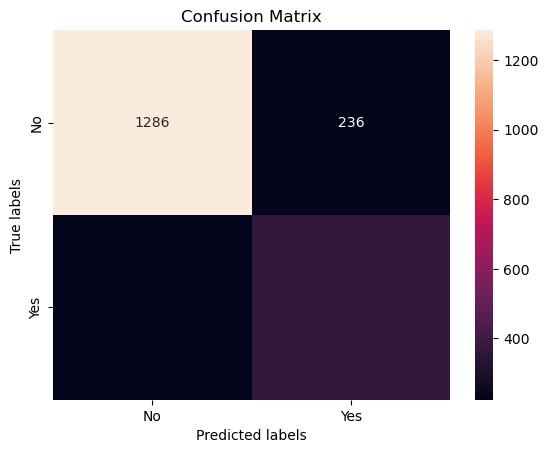

In [57]:
# Confusion Matrices typically are displayed in a graphical manner. Run this cell to display the matrix using this code snippet found online.
labels = ['No','Yes']
ax= plt.subplot()
sn.heatmap(cm, annot=True, ax = ax, fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)
plt.show()

In [59]:
# TASK: Calculate the 4 following metrics using the correct function
# OPTIONAL: Calculate these metrics by hand (using the formulas in the reference blog posts) to validate the values

# 1. Accuracy = Sum of correctly predicted outcomes divided by total number of samples
accuracy = accuracy_score(y_test, pred_test)
print("Accuracy: {:.5f}".format(accuracy))

Accuracy: 0.78199


In [61]:
# 2. Precision - Of those predicted positive, how many of them are actual positive.
precision = precision_score(y_test,pred_test)
print("Precision: {:.5f}".format(precision))

Precision: 0.60667


In [63]:
# 3. Recall - how many of the actual positives our model is predicting as positives
recall = recall_score(y_test,pred_test)
print("Recall: {:.5f}".format(recall))

Recall: 0.61905


In [65]:
# 4. F1 score
f1 = f1_score(y_test, pred_test)
print("F1 Score: {:.5f}".format(f1))

F1 Score: 0.61279


In [67]:
# Alternatively, we can calculate all these metrics in one call using the classification_report function
print(classification_report(y_test, pred_test, digits=5))

              precision    recall  f1-score   support

           0    0.85166   0.84494   0.84828      1522
           1    0.60667   0.61905   0.61279       588

    accuracy                        0.78199      2110
   macro avg    0.72916   0.73199   0.73054      2110
weighted avg    0.78338   0.78199   0.78266      2110



At this point, take a step back and try to understand these numbers. 

- What do these metrics mean in the context of the problem? 
- Which error (Type 1 or Type 2) is more important for this problem? And thus which metric is more important, Precision or Recall?

In [71]:
# TASK: Compute ROC and AUC. Note that roc_curve() returns 3 values. You will only need the first 2 as input to auc() i.e. use _ as the 3rd output
fpr, tpr, _ = roc_curve(y_test, pred_test)
roc_auc = auc(fpr, tpr)

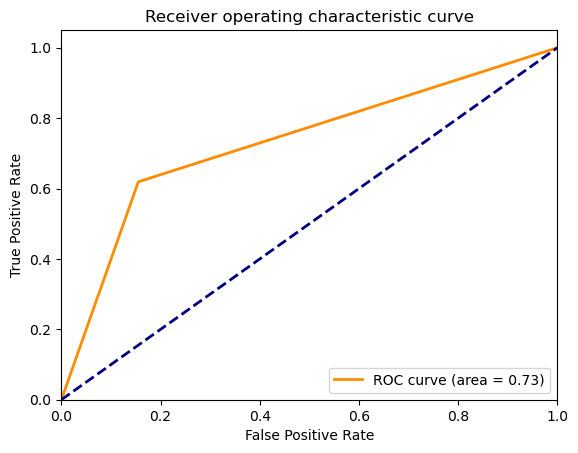

In [73]:
# Run this cell to plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()